In [1]:
from os.path import join
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import proplot as pplt
import seaborn as sns
from tqdm import trange
from tqdm import tqdm

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
folder = 'data/sensitivity_scan/'

In [4]:
phase_devs_x = np.degrees(np.loadtxt(join(folder, 'phase_devs_x.dat')))
phase_devs_y = np.degrees(np.loadtxt(join(folder, 'phase_devs_y.dat')))
C = np.loadtxt(join(folder, 'condition_numbers.dat'))
Cxx = np.loadtxt(join(folder, 'condition_numbers_xx.dat'))
Cyy = np.loadtxt(join(folder, 'condition_numbers_yy.dat'))
Cxy = np.loadtxt(join(folder, 'condition_numbers_xy.dat'))
Csum = Cxx + Cyy + Cxy
fail_rates = np.loadtxt(join(folder, 'fail_rates.dat'))
eps_x_means = 1e6 * np.loadtxt(join(folder, 'eps_x_means.dat'))
eps_y_means = 1e6 * np.loadtxt(join(folder, 'eps_y_means.dat'))
eps_1_means = 1e6 * np.loadtxt(join(folder, 'eps_1_means.dat'))
eps_2_means = 1e6 * np.loadtxt(join(folder, 'eps_2_means.dat'))
eps_x_stds = 1e6 * np.loadtxt(join(folder, 'eps_x_stds.dat'))
eps_y_stds = 1e6 * np.loadtxt(join(folder, 'eps_y_stds.dat'))
eps_1_stds = 1e6 * np.loadtxt(join(folder, 'eps_1_stds.dat'))
eps_2_stds = 1e6 * np.loadtxt(join(folder, 'eps_2_stds.dat'))
eps_x_true, eps_y_true, eps_1_true, eps_2_true = 1e6 * np.loadtxt(join(folder, 'true_emittances.dat'))

In [5]:
total_fail_idx = np.where(fail_rates >= 0.99)
arrays = [eps_1_means, eps_2_means, eps_1_stds, eps_2_stds]
for i in range(len(arrays)):
    arrays[i][total_fail_idx] = None

In [6]:
eps_x_errs = eps_x_means - eps_x_true
eps_y_errs = eps_y_means - eps_y_true
eps_1_errs = eps_1_means - eps_1_true
eps_2_errs = eps_2_means - eps_2_true

In [7]:
plot_kws = dict(colorbar=True)

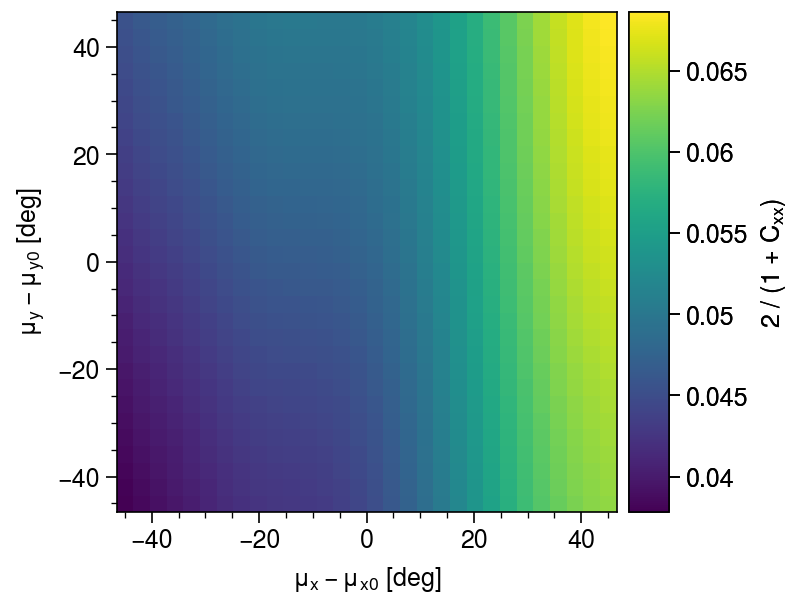

In [17]:
fig, ax = pplt.subplots()
Z = 2.0 / (1.0 + Cxx)
ax.pcolormesh(phase_devs_x, phase_devs_y, Z.T, 
              colorbar_kw=dict(label=r'2 / (1 + $C_{xx}$)'),
              **plot_kws
             )
ax.format(xlabel=r'$\mu_x - \mu_{x0}$ [deg]', ylabel=r'$\mu_y - \mu_{y0}$ [deg]')
plt.savefig('figures/inv_condition_numbers_xx')
plt.show()

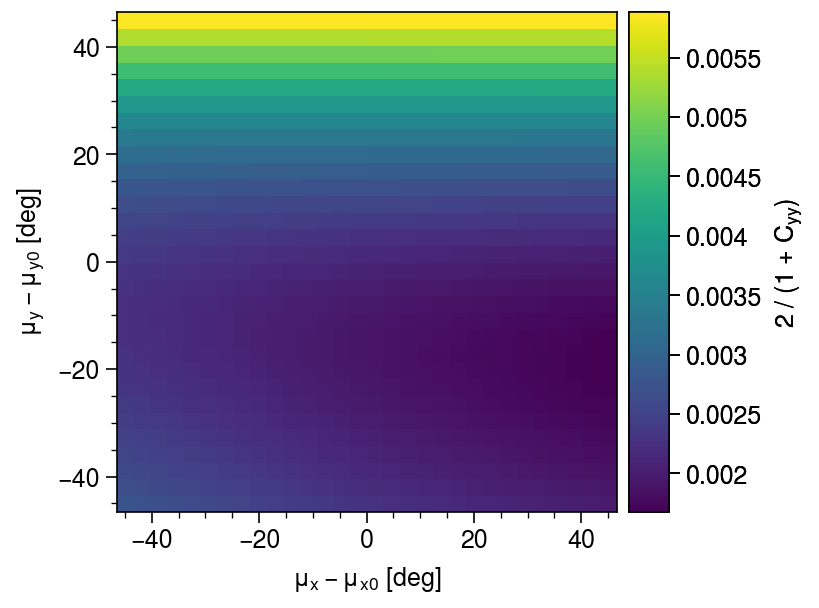

In [19]:
fig, ax = pplt.subplots()
Z = 2.0 / (1.0 + Cyy)
ax.pcolormesh(phase_devs_x, phase_devs_y, Z.T, 
              colorbar_kw=dict(label=r'2 / (1 + $C_{yy}$)'),
              **plot_kws)
ax.format(xlabel=r'$\mu_x - \mu_{x0}$ [deg]', ylabel=r'$\mu_y - \mu_{y0}$ [deg]')
plt.savefig('figures/inv_condition_numbers_yy')
plt.show()

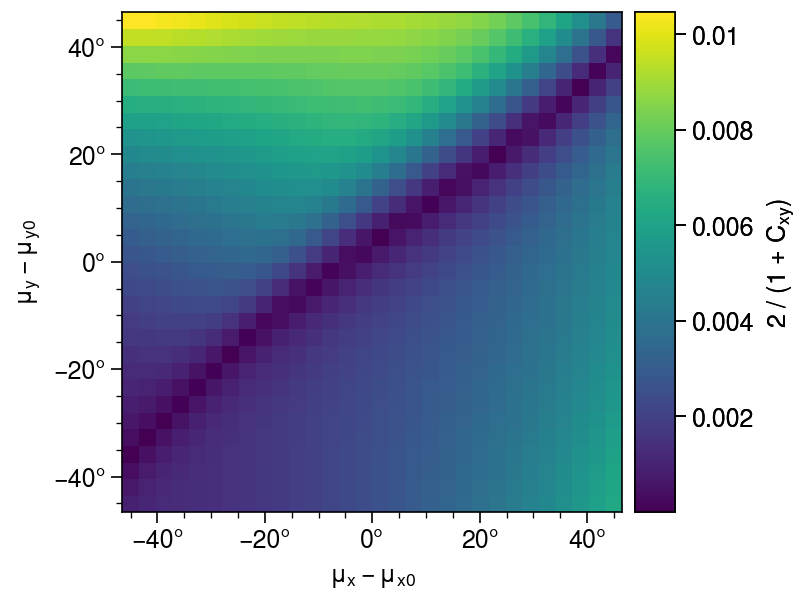

In [20]:
fig, ax = pplt.subplots()
Z = 2.0 / (1.0 + Cxy)
ax.pcolormesh(phase_devs_x, phase_devs_y, Z.T,
              cmap='viridis',
              colorbar_kw=dict(label=r'2 / (1 + $C_{xy}$)'),
              **plot_kws)
ax.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$',
          xformatter='deg', yformatter='deg')
plt.savefig('figures/inv_condition_numbers_xy')
plt.show()

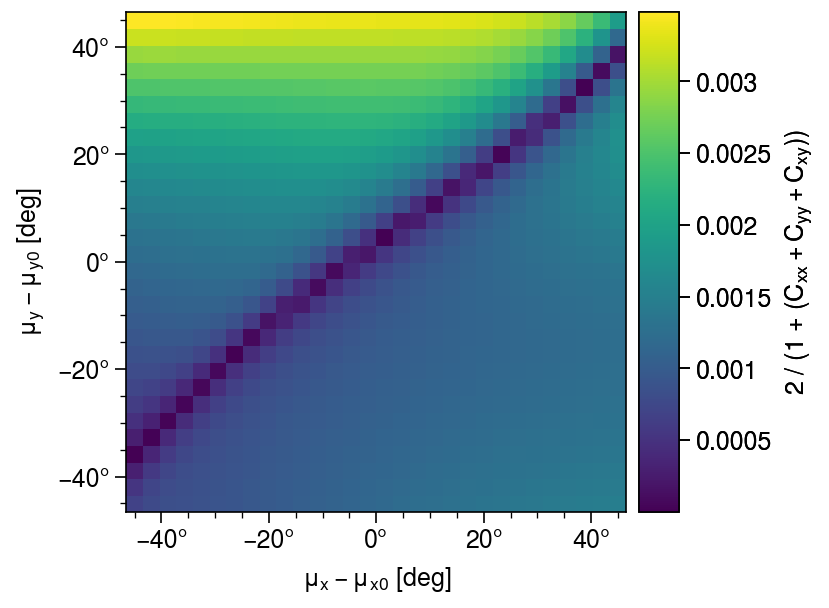

In [21]:
fig, ax = pplt.subplots()
Z = 2.0 / (1.0 + (Cxx + Cxy + Cyy))
ax.pcolormesh(phase_devs_x, phase_devs_y, Z.T, cmap='viridis',
              colorbar_kw=dict(label=r'2 / (1 + ($C_{xx} + C_{yy} + C_{xy}$))'),
              **plot_kws
             )
ax.format(xlabel=r'$\mu_x - \mu_{x0}$ [deg]', ylabel=r'$\mu_y - \mu_{y0}$ [deg]',
          xformatter='deg', yformatter='deg')
plt.savefig('figures/inv_condition_numbers_sum')
plt.show()

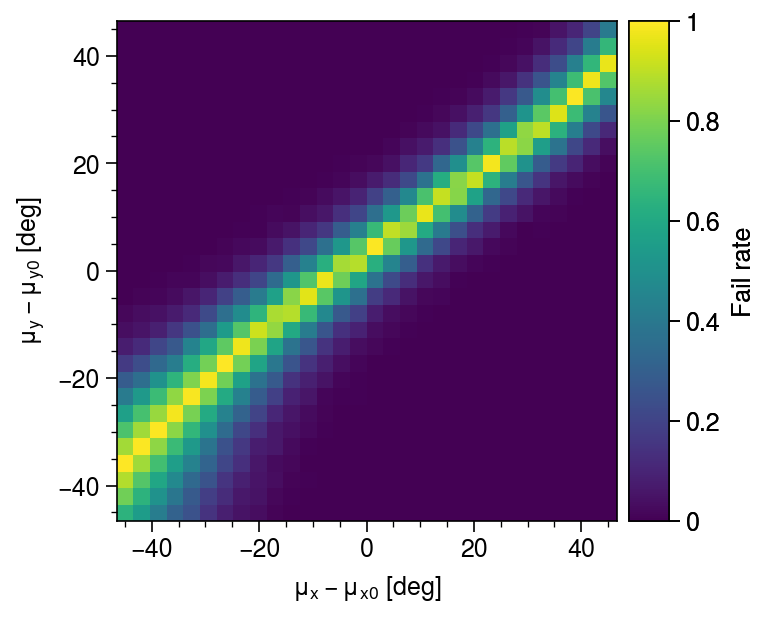

In [22]:
fig, ax = pplt.subplots()
ax.pcolormesh(phase_devs_x, phase_devs_y, fail_rates.T, 
              vmin=0, vmax=1,
              colorbar=True, colorbar_kw=dict(label='Fail rate'))
ax.format(xlabel=r'$\mu_x - \mu_{x0}$ [deg]', ylabel=r'$\mu_y - \mu_{y0}$ [deg]')
plt.savefig('figures/fail_rates')
plt.show()

In [12]:
def plot_condition_numbers(Cxx, Cyy, Cxy, xvals, yvals, 
                           opt='inv', figwidth=8.0, space=None,
                           share=False, **plot_kws):
    Cs = [Cxx, Cyy, Cxy]
    labels = (r'$C_{xx}$', r'$C_{yy}$', r'$C_{xy}$')
    if opt == 'inv':
        Zs = [2.0 / (1.0 + C) for C in Cs]
        cbar_labels = [r'2 / (1 + {})'.format(label) for label in labels]
    elif opt == 'log':
        Zs = [np.log10(C) for C in Cs],
        cbar_labels = [r'$\log_{10} ({})$'.format(label) for label in labels]
    plot_kws.setdefault('ec', 'None')
    vmin = min(np.min(Z) for Z in Zs) if share else None
    vmax = max(np.max(Z) for Z in Zs) if share else None
    fig, axes = pplt.subplots(ncols=3, figwidth=figwidth, space=space)
    for ax, Z, label in zip(axes, Zs, cbar_labels):
        m = ax.pcolormesh(xvals, yvals, Z.T, vmin=vmin, vmax=vmax, **plot_kws)
        ax.colorbar(m, width=0.1, loc='right')
        ax.set_title(label, fontsize='large')
    axes.format(titlepad=12.0)
    return axes

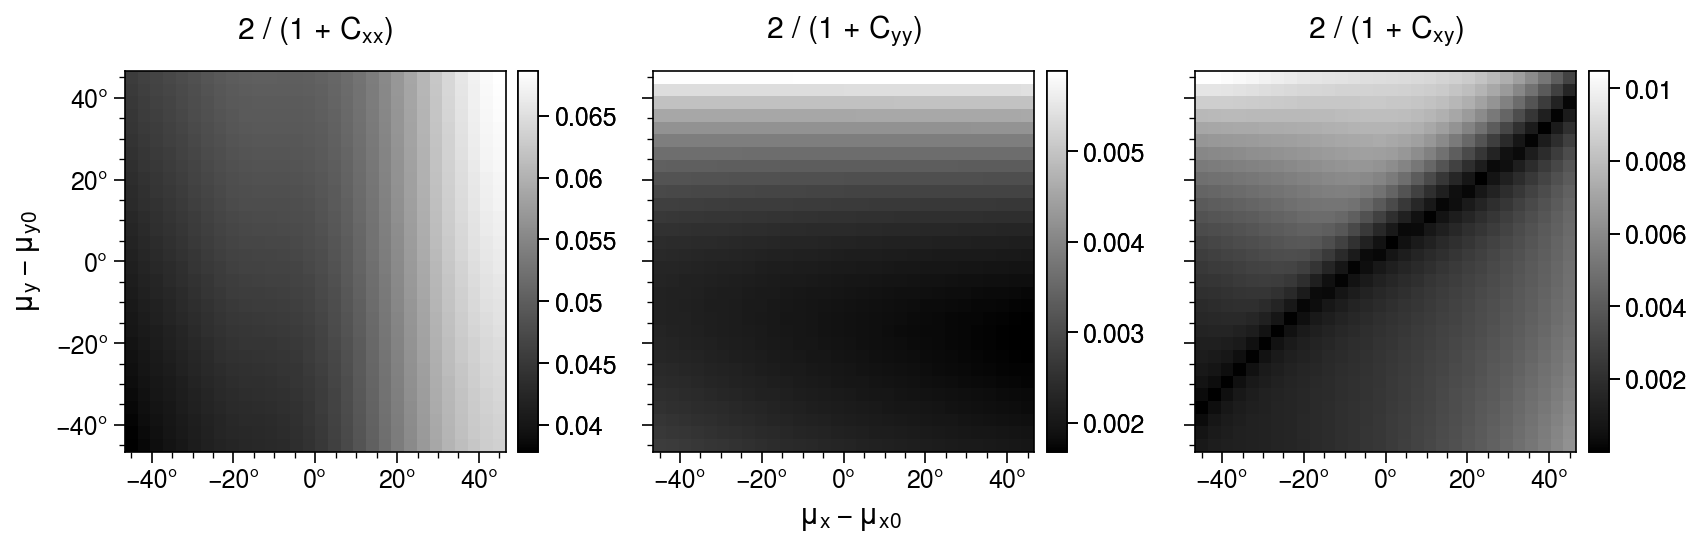

In [24]:
grey = pplt.Colormap('mono_r', right=1.0)
axes = plot_condition_numbers(Cxx, Cyy, Cxy, phase_devs_x, phase_devs_y, cmap=grey, figwidth=8.5)
axes.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$', 
            xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'),
            xformatter='deg', yformatter='deg')

In [8]:
errs = [eps_x_errs, eps_y_errs, eps_1_errs, eps_2_errs]
stds = [eps_x_stds, eps_y_stds, eps_1_stds, eps_2_stds]
frac_errs = [
    eps_x_errs / eps_x_true, 
    eps_y_errs / eps_y_true, 
    eps_1_errs / eps_1_true, 
    eps_2_errs / eps_2_true
]
frac_stds = [
    eps_x_stds / eps_x_true,
    eps_y_stds / eps_y_true,
    eps_1_stds / eps_1_true, 
    eps_2_stds / eps_2_true,
]
vmax = np.nanmax(frac_errs)
vmin = np.nanmin(frac_errs)
vmax = max(abs(vmax), abs(vmin))
vmin = -vmax

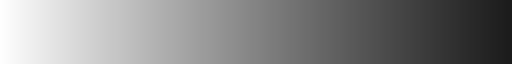

In [9]:
cmap = pplt.Colormap('mono', left=0.0, right=0.9)
cmap

In [10]:
colorbar_kws = dict(loc='right', width=0.1)
eps_labels = [r'$\varepsilon_x$', r'$\varepsilon_y$',
              r'$\varepsilon_1$', r'$\varepsilon_2$']
vmax_frac_errs = max(abs(np.nanmax(frac_errs)), abs(np.nanmin(frac_errs)))
vmax_frac_stds = np.nanmax(frac_stds)
vmin_frac_stds = np.nanmin(frac_stds)
share = False

# fig, axes = pplt.subplots(ncols=4, nrows=2, space=None, figwidth=9.5)
# for ax, err in zip(axes[0, :], frac_errs):
#     vmax_ = vmax_frac_errs if share else max(abs(np.nanmax(err)), abs(np.nanmin(err))) 
#     m = ax.pcolormesh(phase_devs_x, phase_devs_y, err.T,
#                       cmap='Vlag', diverging=True, 
#                       vmax=vmax_, vmin=-vmax_,
#                       ec='None',)
#     if not share:
#         ax.colorbar(m, label='frac. error' if ax is axes[0, -1] else '', **colorbar_kws)
# if share:
#     fig.colorbar(m, ax=axes[0, -1], label='frac. error', **colorbar_kws)
# for ax, std in zip(axes[1, :], frac_stds):
#     vmax_ = vmax_frac_stds if share else max(abs(np.nanmax(std)), abs(np.nanmin(std)))
#     m = ax.pcolormesh(phase_devs_x, phase_devs_y, std.T, cmap=cmap,
#                       vmin=0.0, vmax=vmax_, ec='None',)
#     if not share:
#         ax.colorbar(m, label='frac. std' if ax is axes[1, -1] else '', **colorbar_kws)
# if share:
#     fig.colorbar(m, ax=axes[1, -1], label='frac. std', **colorbar_kws)
# axes.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$',
#             xformatter='deg', yformatter='deg',
#             toplabels=eps_labels, 
#             toplabels_kw=dict(fontweight='normal', fontsize='large'),
#             xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large')
#            )
# plt.savefig('figures/montecarlo_emittances')
# plt.show()

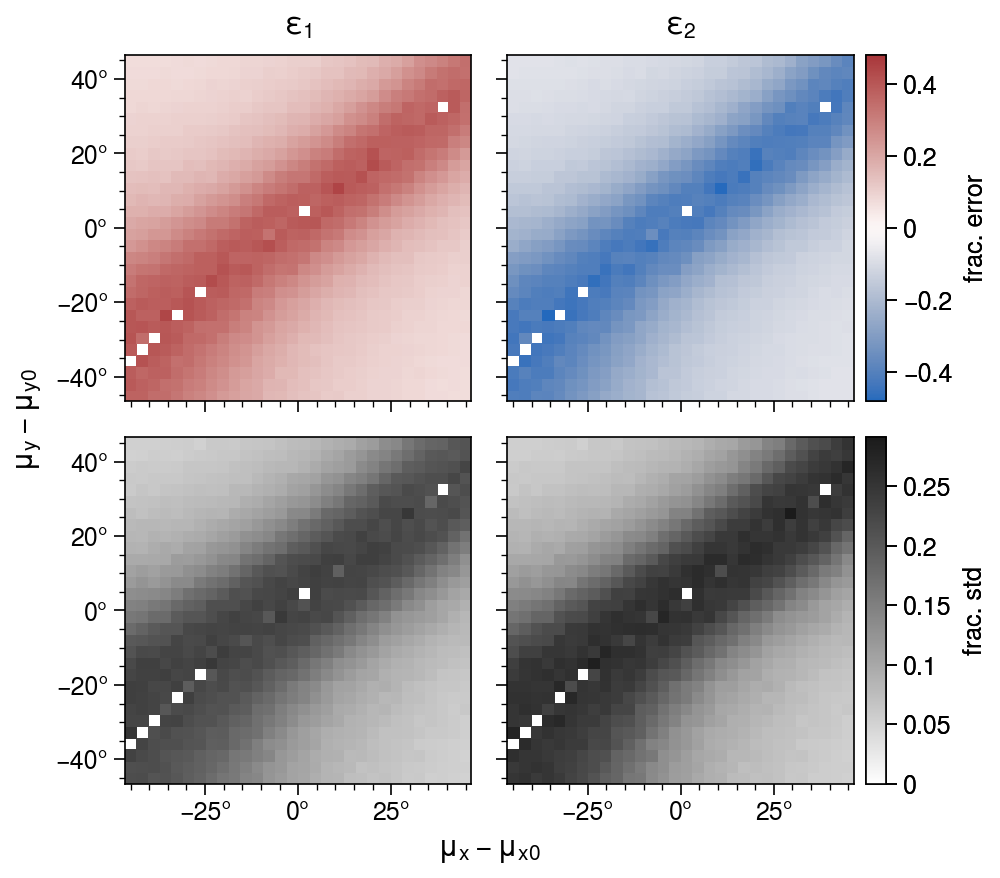

In [11]:
colorbar_kws = dict(loc='right', width=0.1)

fig, axes = pplt.subplots(nrows=2, ncols=2, figwidth=5.0)
vmax = np.nanmax(np.abs(frac_errs[2:]))
for ax, err in zip(axes[0, :], frac_errs[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, err.T, 
                      diverging=True, cmap='Vlag', vmax=vmax, vmin=-vmax)
axes[0, 1].colorbar(m, label='frac. error', **colorbar_kws)
vmin = 0.0
vmax = np.nanmax(frac_stds[2:])
for ax, std in zip(axes[1, :], frac_stds[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, std.T, cmap=cmap,
                      vmin=vmin, vmax=vmax, 
                     )
axes[1, 1].colorbar(m, label='frac. std', **colorbar_kws)
fontsize = 'large'
axes.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$',
            xformatter='deg', yformatter='deg',
            toplabels=eps_labels[2:],
            toplabels_kw=dict(fontweight='normal', fontsize=fontsize),
            xlabel_kw=dict(fontsize=fontsize),
            ylabel_kw=dict(fontsize=fontsize),
           )
plt.savefig('figures/rtbt_montecarlo_emittances')
plt.show()

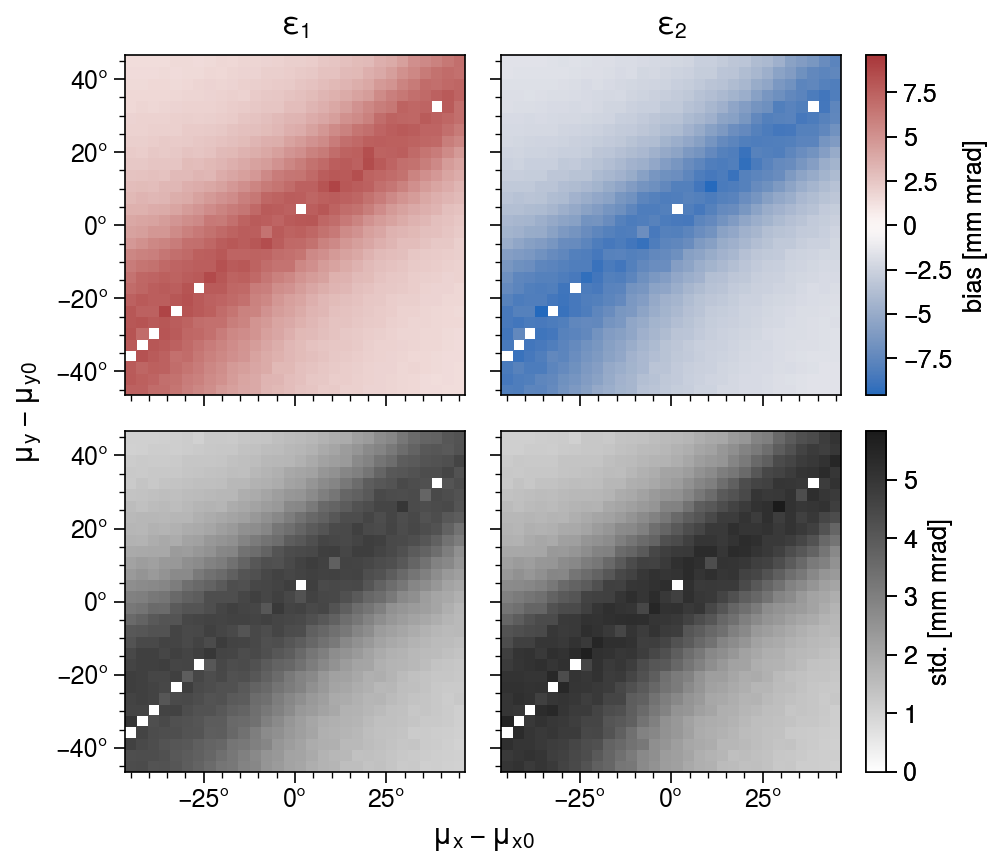

In [11]:
colorbar_kws = dict(loc='right', space=1.0, width=0.1)

fig, axes = pplt.subplots(nrows=2, ncols=2, figwidth=5.0)
vmax = np.nanmax(np.abs(errs[2:]))
for ax, err in zip(axes[0, :], errs[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, err.T, 
                      diverging=True, cmap='Vlag', vmax=vmax, vmin=-vmax)
axes[0, 1].colorbar(m, label='bias [mm mrad]', **colorbar_kws)
vmin = 0.0
vmax = np.nanmax(stds[2:])
for ax, std in zip(axes[1, :], stds[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, std.T, cmap=cmap,
                      vmin=vmin, vmax=vmax, 
                     )
axes[1, 1].colorbar(m, label='std. [mm mrad]', **colorbar_kws)
fontsize = 'large'
axes.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$',
            xformatter='deg', yformatter='deg',
            toplabels=eps_labels[2:],
            toplabels_kw=dict(fontweight='normal', fontsize=fontsize),
            xlabel_kw=dict(fontsize=fontsize),
            ylabel_kw=dict(fontsize=fontsize),
           )
plt.savefig('figures/rtbt_montecarlo_emittances2')
plt.show()

In [ ]:
colorbar_kws = dict(loc='right', width=0.1)

fig, axes = pplt.subplots(nrows=2, ncols=2, figwidth=5.5)
vmax = np.nanmax(np.abs(errs[2:]))
for ax, err in zip(axes[0, :], errs[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, err.T, ec='None',
                      diverging=True, cmap='Vlag', vmax=vmax, vmin=-vmax)
axes[0, 1].colorbar(m, label='error [mm mrad]', **colorbar_kws)
vmax = np.nanmax(stds[2:])
for ax, std in zip(axes[1, :], stds[2:]):
    m = ax.pcolormesh(phase_devs_x, phase_devs_y, std.T, vmin=0, vmax=vmax, ec='None')
axes[1, 1].colorbar(m, label='std. [mm mrad]', **colorbar_kws)
axes.format(xlabel=r'$\mu_x - \mu_{x0}$', ylabel=r'$\mu_y - \mu_{y0}$',
            xformatter='deg', yformatter='deg',
#             toplabels=eps_labels[2:],
#             toplabels_kw=dict(fontweight='normal')
           )
plt.savefig('_output/figures/rtbt_mc_emittances.png', dpi=400)
plt.show()

In [ ]:
for i in [2, 3]:
    print('i =', i)
    print(errs[i][-1, :])
    print()
    print(stds[i][-1, :])
    print()
    print()

In [ ]:
titles = ['eps_x_errs', 'eps_y_errs', 'eps_1_errs', 'eps_2_errs', 
          'eps_x_stds', 'eps_y_stds', 'eps_1_stds', 'eps_2_stds']
datas = [eps_x_errs, eps_y_errs, eps_1_errs, eps_2_errs,
         eps_x_stds, eps_y_stds, eps_1_stds, eps_2_stds]

for data in datas:
    data[data == 0.0] = None

for title, data in zip(titles, datas):
    fig, ax = pplt.subplots()
    ax.pcolormesh(phase_devs_x, phase_devs_y, data.T, 
                  vmin=0.0 if 'std' in title else None,
                  diverging='std' not in title,
                  cmap=None if 'std' in title else 'Vlag',
                  colorbar=True, colorbar_kw=dict(label='[mm mrad]'))
#     for (dmux, dmuy) in dmus:
#         ax.scatter(dmux, dmuy, color='red')
    ax.format(xlabel=r'$\mu_x - \mu_{x0}$ [deg]', ylabel=r'$\mu_y - \mu_{y0}$ [deg]', title=title, 
             )
    plt.show()

In [ ]:
model = np.array([-0.75, 1.91, 5.62, 19.40])
meas = np.array([-0.65, 1.17, 5.78, 20.41])
(model - meas) / model

## Plot

In [4]:
def rotation_matrix_2D(mu):
    return np.array([[np.cos(mu), np.sin(mu)], [-np.sin(mu), np.cos(mu)]])

def rotation_matrix_4D(mux, muy):
    M = np.zeros((4, 4))
    M[:2, :2] = rotation_matrix_2D(mux)
    M[2:, 2:] = rotation_matrix_2D(muy)
    return M

def get_tmats(dmux, dmuy):
    return [rotation_matrix_4D(i * dmux, i * dmuy) for i in range(4)]
        
def cond(A):
    A = np.array(A)
    inv = np.linalg.inv if A.shape[0] == A.shape[1] else np.linalg.pinv
    return np.linalg.norm(A) * np.linalg.norm(inv(A))

n = 150
pad = 0.1
dmuxx = np.radians(np.linspace(0.0 + pad, 180.0 - pad, n))
dmuyy = np.radians(np.linspace(0.0 + pad, 180.0 - pad, n))
Cxx = np.zeros((n, n))
Cyy = np.zeros((n, n))
Cxy = np.zeros((n, n))
for i, dmux in enumerate(tqdm(dmuxx)):
    for j, dmuy in enumerate(dmuyy):  
        Axx, Ayy, Axy = [], [], []
        for M in get_tmats(dmux, dmuy):
            Axx.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1]])
            Ayy.append([M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3]])
            Axy.append([M[0, 0]*M[2, 2], M[0, 1]*M[2, 2], M[0, 0]*M[2, 3], M[0, 1]*M[2, 3]])
        Cxx[i, j] = cond(Axx)
        Cyy[i, j] = cond(Ayy)
        Cxy[i, j] = cond(Axy)

100%|██████████| 150/150 [00:09<00:00, 16.63it/s]


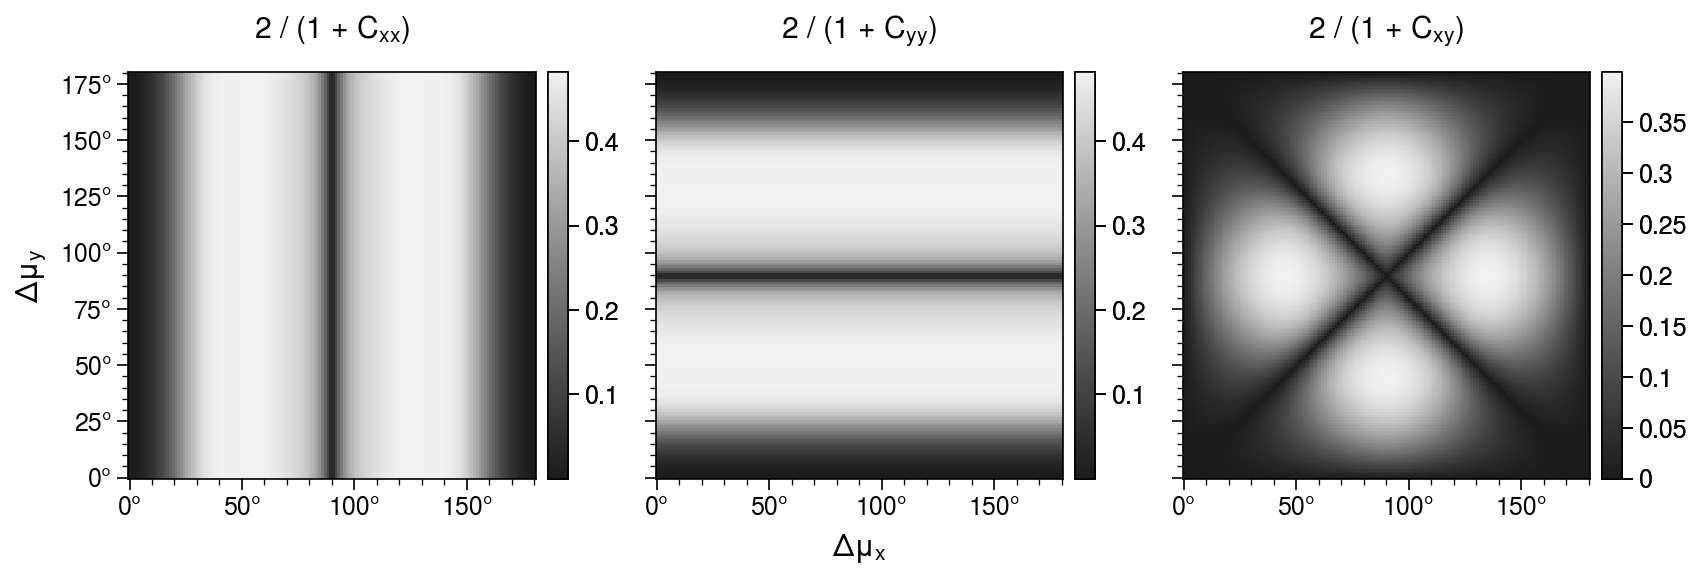

In [18]:
axes = plot_condition_numbers(Cxx, Cyy, Cxy, 
                              np.degrees(dmuxx),
                              np.degrees(dmuyy), 
                              cmap=pplt.Colormap('mono_r', left=0.1, right=0.95), ec=None,
                              figwidth=8.5)
axes.format(xlabel=r'$\Delta\mu_x$', ylabel=r'$\Delta\mu_y$', 
            xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'),
            xformatter='deg', yformatter='deg')
plt.savefig('figures/condition_numbers')

In [ ]:
def getZ(C):
    return 2.0 / (1.0 + C)

Z = getZ(Cxx + Cyy + Cxy)
fig, ax = pplt.subplots()
ax.pcolormesh(Z.T, cmap='mono_r', ec='None', colorbar=True, colorbar_kw=dict(label=r'2'))